# Week 1 Project

**Students**: Sergio Casas Pastor, Sanket Biswas and Josep Brugués i Pujolràs

In [1]:
import cv2
import numpy as np
import cPickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import time
from matplotlib import pyplot as plt

Let us first read the train and test files

In [2]:
train_images_filenames = cPickle.load(open('train_images_filenames.dat','r'))
test_images_filenames = cPickle.load(open('test_images_filenames.dat','r'))
train_labels = cPickle.load(open('train_labels.dat','r'))
test_labels = cPickle.load(open('test_labels.dat','r'))

In [3]:
train_images_filenames[12]

'../../Databases/MIT_split/train/Opencountry/fie26.jpg'

We create a SIFT object detector and descriptor

In [4]:
SIFTdetector = cv2.xfeatures2d.SIFT_create(nfeatures=900)
start = time.time()

We compute the SIFT descriptors for all the train images and subsequently build a numpy array with all the descriptors stacked together

In [5]:
Train_descriptors = []
Train_label_per_descriptor = []

for filename,labels in zip(train_images_filenames,train_labels):
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
    
#     step = 40
#     kpt = []
    
#     for i in xrange(step/2, ima.shape[0], step):
#         for j in xrange(step/2, ima.shape[1], step):
#             kpt.append(cv2.KeyPoint(i, j, step))
     
#     kpt,des=SIFTdetector.compute(gray,kpt)

    kpt,des=SIFTdetector.detectAndCompute(gray,None)

#     outImage = ima
#     outImage = cv2.drawKeypoints(ima, kpt, outImage)
#     cv2.imshow("Image", outImage)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    
    Train_descriptors.append(des)
    Train_label_per_descriptor.append(labels)

D=np.vstack(Train_descriptors)

We now compute a k-means clustering on the descriptor space

In [6]:
k = 170
codebook = MiniBatchKMeans(n_clusters=k, verbose=False, batch_size=k * 20,compute_labels=False,reassignment_ratio=10**-4,random_state=42)
codebook.fit(D)

MiniBatchKMeans(batch_size=3400, compute_labels=False, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10,
        n_clusters=170, n_init=3, random_state=42,
        reassignment_ratio=0.0001, tol=0.0, verbose=False)

And, for each train image, we project each keypoint descriptor to its closest visual word. We represent each of the images with the frequency of each visual word.

In [7]:
visual_words=np.zeros((len(Train_descriptors),k),dtype=np.float32)
for i in xrange(len(Train_descriptors)):
    words=codebook.predict(Train_descriptors[i])
    visual_words[i,:]=np.bincount(words,minlength=k)

We build a k-nn classifier and train it with the train descriptors

In [8]:
knn = KNeighborsClassifier(n_neighbors=20,n_jobs=-1,metric='euclidean')
knn.fit(visual_words, train_labels) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
           weights='uniform')

We end up computing the test descriptors and compute the accuracy of the model

In [9]:
visual_words_test=np.zeros((len(test_images_filenames),k),dtype=np.float32)
for i in range(len(test_images_filenames)):
    filename=test_images_filenames[i]
    ima=cv2.imread(filename)
    gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
#     step = 40
#     kpt = []
    
#     for i in xrange(step/2, ima.shape[0], step):
#         for j in xrange(step/2, ima.shape[1], step):
#             kpt.append(cv2.KeyPoint(i, j, step))
     
#     kpt,des=SIFTdetector.compute(gray,kpt)
    
    kpt,des=SIFTdetector.detectAndCompute(gray,None)
    words=codebook.predict(des)
    visual_words_test[i,:]=np.bincount(words,minlength=k)

In [10]:
accuracy = 100*knn.score(visual_words_test, test_labels)
print(accuracy)
end = time.time()
print(end - start)

62.949194547707556
95.3732328415


Dimensionality reduction, with PCA and LDA

In [11]:
pca = PCA(n_components=64)
VWpca = pca.fit_transform(visual_words)
knnpca = KNeighborsClassifier(n_neighbors=20,n_jobs=-1,metric='euclidean')
knnpca.fit(VWpca, train_labels) 
vwtestpca = pca.transform(visual_words_test)
accuracy = 100*knnpca.score(vwtestpca, test_labels)
print(accuracy)

63.073110285006194


In [12]:
lda = LinearDiscriminantAnalysis(n_components=64)
VWlda = lda.fit_transform(visual_words,train_labels)
knnlda = KNeighborsClassifier(n_neighbors=20,n_jobs=-1,metric='euclidean')
knnlda.fit(VWlda, train_labels) 
vwtestlda = lda.transform(visual_words_test)
accuracy = 100*knnlda.score(vwtestlda, test_labels)
print(accuracy)

65.79925650557621


**RESULTS AND DISCUSSION**

We test different amount of local features.
We keep the rest of the parameters with initial values (SIFT, Codebook size k = 128, neighbours k = 5, euclidean distance, no reduction)

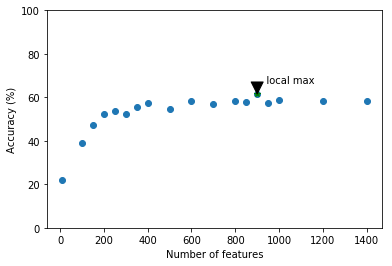

In [13]:
number = [10, 100, 150, 200, 250, 300, 350, 400, 500, 600, 700, 800, 850, 900, 950, 1000, 1200, 1400]
accuracy = [22.18, 39.03, 47.21, 52.42, 53.53, 52.42, 55.64, 57.5, 54.77, 58.24, 56.88, 58.11, 57.74, 61.34, 57.49, 58.99, 58.36, 58.49]
plt.scatter(number, accuracy)
plt.plot(number[13], accuracy[13], 'g*')
plt.ylim((0, 100))
plt.xlabel("Number of features")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = number[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()

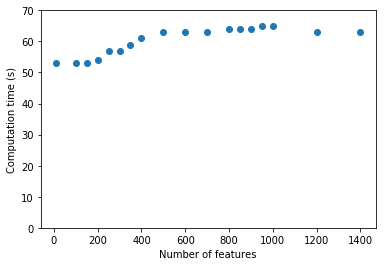

In [14]:
time = [53, 53, 53, 54, 57, 57, 59, 61, 63, 63, 63, 64, 64, 64, 65, 65, 63, 63]
plt.scatter(number, time)
plt.ylim((0, 70))
plt.xlabel("Number of features")
plt.ylabel("Computation time (s)")
plt.show()

We got the maximum accuracy with 900 features. The computation time is very similar using different number of features. Therefore, we conclude that, using SIFT feature detector, Codebook size 128, 5 k-nn neighbours, euclidean distance and no reduction, the best performance is with approximate 900 features.

We now use dense SIFT instead of detected keypoints. This way, the detected keypoints are equally distributed in the image and not only in the interesting points. There is a parameter (step size) we can vary to create different distributions. We again keep the rest of the parameters like before.

Example of dense SIFT


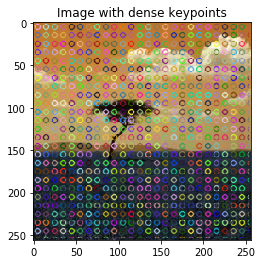

In [15]:
print("Example of dense SIFT")
filename=train_images_filenames[1]
ima=cv2.imread(filename)
gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
step = 10
kpt = []
    
for i in xrange(step/2, ima.shape[0], step):
    for j in xrange(step/2, ima.shape[1], step):
        kpt.append(cv2.KeyPoint(i, j, step))
     
kpt,des=SIFTdetector.compute(gray,kpt)

keypointsIma = ima
keypointsIma = cv2.drawKeypoints(ima, kpt, keypointsIma)
plt.imshow(keypointsIma)
plt.title('Image with dense keypoints')
plt.show()

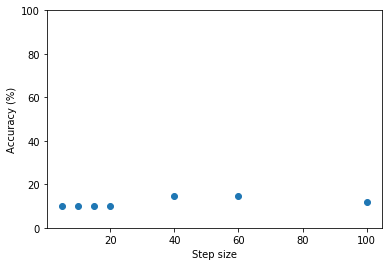

In [16]:
step = [5, 10, 15, 20, 40, 60, 100]
accuracy = [9.91, 9.91, 9.91, 9.91, 14.62, 14.62, 11.64]
plt.scatter(step, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
plt.show()

Dense SIFT keypoint detector produces much worse results than normal SIFT keypoint detector because the keypoints are not only in the interesting regions.

Using the best number of features found, and without using desne SIFT, we then find which is the best number of codewords for the k-means. We first iterated over the powers of 2. Once the best two values were found, we precised the k parameter a little bit more just to get the best result possible.

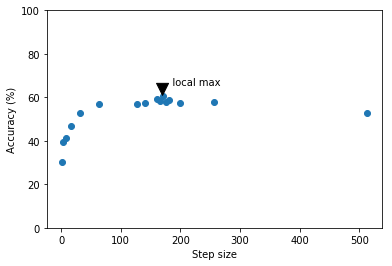

Local max is 60.71 % accuracy at k= 170


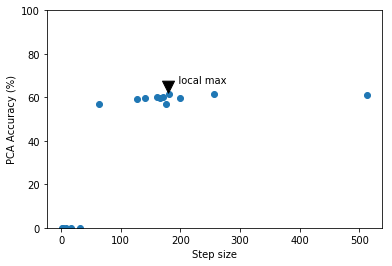

Local max is 61.71 % PCA accuracy at k= 180


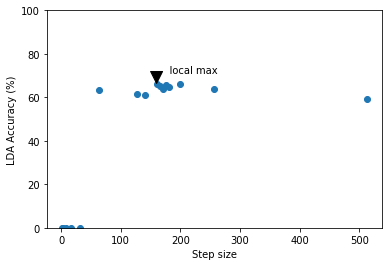

Local max is 66.17 % LDA accuracy at k= 160


In [17]:
k = [2,4,8,16,32,64,128,140,160,165,170,175,180,200,256,512]
accuracy = [30.23,39.28,41.14,46.71,52.91,56.75,56.87,57.62,59.1,58.48,60.71,57.74,58.98, 57.24,57.74,52.91]
pca_accuracy = [0,0,0,0,0,56.75,59.23,59.47,60.22,59.72,60.09,57.12,61.71,59.6,61.58,61.09]
lda_accuracy = [0,0,0,0,0,63.19,61.71,61.21,66.17,65.03,63.94,65.67,64.93,65.92,63.81,59.1]

plt.scatter(k, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% accuracy at k=",xmax

plt.scatter(k, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% PCA accuracy at k=",xmax


plt.scatter(k, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print "Local max is", ymax,"% LDA accuracy at k=",xmax


Overall, we think that k=170 es the best option since it gets the best accuracy without applying any feature reduction algorithm. If we look at the computational time, there is almost no overhead added with different changes in the K value (if we take into account that a slower processor than before has been used). 

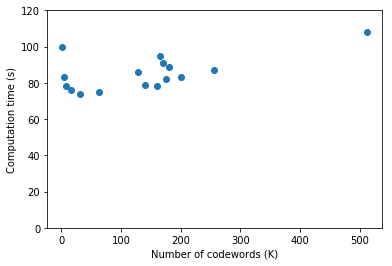

In [18]:
k = [2,4,8,16,32,64,128,140,160,165,170,175,180,200,256,512]
time = [100,83,78,76,74,75,86,79,78,95,91,82,89,83,87,108]
plt.scatter(k, time)
plt.ylim((0, 120))
plt.xlabel("Number of codewords (K)")
plt.ylabel("Computation time (s)")
plt.show()

Once the best number of codewords was established, we looked to optimize the number of neighbours taken into account by the K-NN classifier. We used the best number of features (900) and the best number of codewords (170), leaving the rest of parameters as default. 

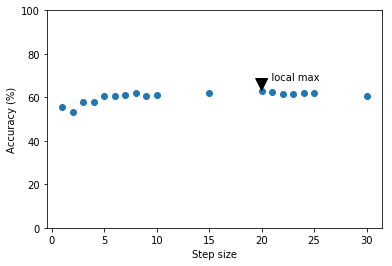

Local max is 62.94 % accuracy at k= 20


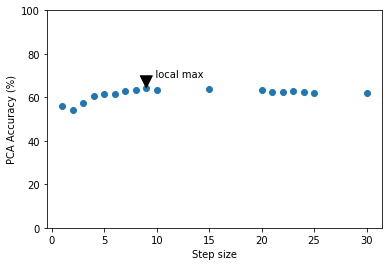

Local max is 64.18 % PCA accuracy at k= 9


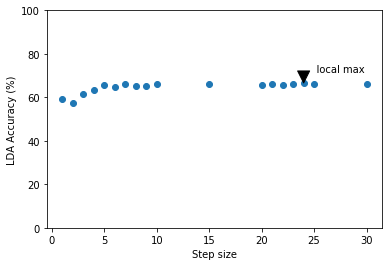

Local max is 66.41 % LDA accuracy at k= 24


In [19]:
k = [1,2,3,4,5,6,7,8,9,10,15,20,21,22,23,24,25,30]
accuracy = [55.63,53.4,57.99,57.86,60.71,60.47,60.96,61.83,60.71,60.96,62.08,62.94,62.57,61.46,61.46,61.95,62.20,60.47]
pca_accuracy = [56.01,54.27,57.62,60.71,61.33,61.71,62.94,63.19,64.18,63.32,63.81,63.32,62.45,62.57,62.70,62.57,62.08,62.20]
lda_accuracy = [59.1,57.62,61.71,63.56,65.67,64.68,66.17,65.42,65.17,66.17,66.29,65.79,65.92,65.79,66.17,66.41,66.17,66.04]

plt.scatter(k, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
ymax = max(accuracy)
xpos = accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% accuracy at k=",xmax

plt.scatter(k, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("PCA Accuracy (%)")
ymax = max(pca_accuracy)
xpos = pca_accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('   local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()
print "Local max is", ymax,"% PCA accuracy at k=",xmax


plt.scatter(k, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("LDA Accuracy (%)")
ymax = max(lda_accuracy)
xpos = lda_accuracy.index(ymax)
xmax = k[xpos]
plt.annotate('    local max', xy=(xmax, ymax), xytext=(xmax, ymax+5),
            arrowprops=dict(facecolor='black', shrink=0.05),)

plt.show()
print "Local max is", ymax,"% LDA accuracy at k=",xmax

From the results just presented, we think that looking at k=20 neighbours is the best option, since it has the best accuracy without reducing the number of features and, when reducing features, it does not lose much accuracy with respect to the best PCA and LDA results. Despite that, the improvement is not big, taking into account the results obtained before when analysing the number of features and the number of codewords.

After that, we tested different distances for the k-NN algorithm, to see which one was the best suited.

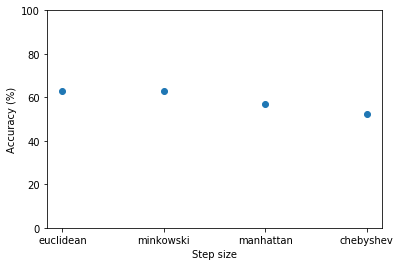

Local max is 66.41 % accuracy at k= 24


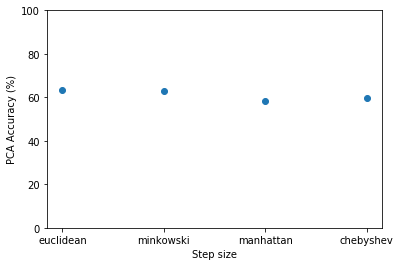

Local max is 66.41 % PCA accuracy at k= 24


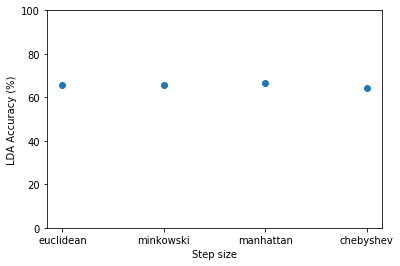

Local max is 66.41 % LDA accuracy at k= 24


In [20]:
distances = ["euclidean","minkowski", "manhattan", "chebyshev"]
accuracy = [62.94,62.94,56.75,52.29]
pca_accuracy = [63.32,62.82,58.36,59.85]
lda_accuracy = [65.79,65.79,66.54,64.31]

plt.scatter(distances, accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("Accuracy (%)")
plt.show()
print "Local max is", ymax,"% accuracy at k=",xmax

plt.scatter(distances, pca_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("PCA Accuracy (%)")
plt.show()
print "Local max is", ymax,"% PCA accuracy at k=",xmax


plt.scatter(distances, lda_accuracy)
plt.ylim((0, 100))
plt.xlabel("Step size")
plt.ylabel("LDA Accuracy (%)")
plt.show()
print "Local max is", ymax,"% LDA accuracy at k=",xmax

As we can see from the plots above, the best performing distance is the euclidean (when not performing any kind of feature reduction). This is because